## Classificação de compostos químicos e métodos de interpretabilidade

Objetivo : classificação de compostos químicos baseada na sua capacidade de interagir com a proteína p53 (elemento importante na prevenção do desenvolvimento de tumores)
Dataset: TOX21

<b>NR-AR, NR-ER, NR-AhR, NR-PPAR-gamma</b>: Esses atributos rep-
resentam a atividade de receptores nucleares, como o receptor de andrógeno
(AR), estrogênio (ER), hidrocarboneto aromático (AhR) e receptor ativado
por proliferadores de peroxissoma-gama (PPAR-gama). Esses receptores es-
tão envolvidos em diversos processos celulares, incluindo crescimento celular,
diferenciação e apoptose, os quais também são regulados pela proteína p53.
Compostos que modulam a atividade desses receptores podem afetar indire-
tamente as vias mediadas por p53

<b>NR-Aromatase</b>: Aromatase é uma enzima envolvida na biossíntese de es-
trogênio. Os receptores de estrogênio (ERs) desempenham um papel na
regulação da expressão e atividade da p53. Compostos que influenciam a
atividade da aromatase podem impactar os níveis de estrogênio, afetando
potencialmente as respostas mediadas por p53.

<b>SR-p53</b>: Este atributo representa a atividade da própria proteína p53.

<b>SR-ARE</b>, SR-ATAD5, SR-HSE, SR-MMP: Esses atributos representam a atividade de receptores xenobióticos ou vias moleculares relacionadas
à resposta celular ao estresse, reparo de DNA e metaloproteinases da matriz.
Embora essas vias possam não interagir diretamente com a p53, elas podem
se intersectar com as vias mediadas por p53, influenciando as respostas celu-
lares ao estresse, danos ao DNA e tumorigênese.

<b>mol_id</b>: Este atributo representa um identificador único atribuído a cada
composto no conjunto de dados. Ele serve como uma referência ou chave para
distinguir um composto de outro dentro do conjunto de dados. O mol_id não
fornece informações sobre a atividade biológica do composto, mas é essencial
para a organização e gestão dos dados.

<b>smiles</b>: SMILES significa Simplified Molecular Input Line Entry System, que
é um sistema de notação usado para representar a estrutura de moléculas
químicas como strings de texto. As strings SMILES codificam o arranjo
de átomos e ligações em uma molécula, fornecendo uma forma compacta e
padronizada de descrever estruturas químicas

In [42]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

In [43]:
ds = pd.read_csv('tox21.csv')

**Data Pre-processing**

In [44]:
ds.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O


In [45]:
ds.shape

(7831, 14)

In [46]:
ds.isnull().sum()

NR-AR             566
NR-AR-LBD        1073
NR-AhR           1282
NR-Aromatase     2010
NR-ER            1638
NR-ER-LBD         876
NR-PPAR-gamma    1381
SR-ARE           1999
SR-ATAD5          759
SR-HSE           1364
SR-MMP           2021
SR-p53           1057
mol_id              0
smiles              0
dtype: int64

Como visto acima é notavel que este dataset contém uma quantidade substancial de valores nulos. Sendo assim, o grupo enfrenta o dilema de como tratar destes valores. Considerando que estes valores são representativos da presença de um certo recetor num composto quimico é possivel assumir que a falta de representação pode significar a falta deste recetor sendo assim possivel substituir o valor nulo por um 0. 

In [47]:
ds.fillna(0, inplace=True)
ds.isnull().sum()

NR-AR            0
NR-AR-LBD        0
NR-AhR           0
NR-Aromatase     0
NR-ER            0
NR-ER-LBD        0
NR-PPAR-gamma    0
SR-ARE           0
SR-ATAD5         0
SR-HSE           0
SR-MMP           0
SR-p53           0
mol_id           0
smiles           0
dtype: int64

A coluna mol_id representa um id usado pela comunidade cientifica para o reconhecimento de um composto quimico por isso não sendo relevante nesta pesquisa. 

In [48]:
print(ds['mol_id'].duplicated().sum())

0


In [49]:
ds.drop('mol_id', axis=1, inplace=True)

In [50]:
ds1 = ds.drop(['smiles'], axis=1)
correlation = ds1.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

'ds1 = ds.drop([\'smiles\'], axis=1)\ncorrelation = ds1.corr()\nplt.figure(figsize=(8, 6))\nsns.heatmap(correlation, annot=True, cmap=\'coolwarm\', fmt=".2f", linewidths=.5)\nplt.title(\'Correlation Matrix\')\nplt.show()'

In [51]:
mols = pd.DataFrame()
mols["smiles"] = ds['smiles'].apply(Chem.MolFromSmiles)

[14:46:18] WARNING: not removing hydrogen atom without neighbors


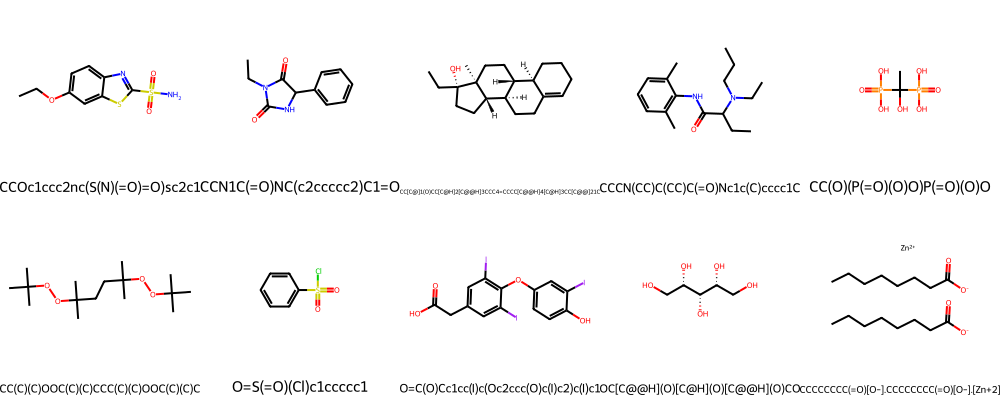

In [52]:
Draw.MolsToGridImage(mols['smiles'][:10],molsPerRow=5,subImgSize=(200,200),legends=[Chem.MolToSmiles(x) for x in mols['smiles'][:10]])

In [53]:
ds.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,smiles
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCN1C(=O)NC(c2ccccc2)C1=O
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CC(O)(P(=O)(O)O)P(=O)(O)O


In [54]:
def getAtrValue(atr,smiles):
    return ds.loc[ds['smiles'] == smiles, atr].iloc[0]

In [55]:
def notactive(n):
    if(n==0.0): return True
    else: return False

def isactive(n):
    if(n==1.0): return True
    else: return False

active = filter(isactive,ds['SR-p53'])
inactive = filter(notactive,ds['SR-p53'])
print("Existem "+str(len(list(active)))+ " compostos químicos reativos à SR-p53.")
print("Existem "+str(len(list(inactive)))+ " compostos químicos não reativos à SR-p53.")

Existem 423 compostos químicos reativos à SR-p53.
Existem 7408 compostos químicos não reativos à SR-p53.


**Get default device as CPU or cuda(GPU) based on availability**

In [56]:
#setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

#force cpu
#device = torch.device("cpu")
print('Using device:', device)

Using device: cpu


**Converter cada uma das moléculas num grafo**

A representação de um grafo pode ser feita convertendo uma molécula (rdkit.chem.mol) para uma instância torch_geometric.data.Data do Pytorch Geometric.

- Podemos utilizar as propriedades de cada molécula do dataset, juntamente com outras fornecidas pela biblioteca rdkit.chem.mol.
- Iterar pelos átomos e adicioná-los num vetor que será convertido para um tensor PyTorch.
- Depois iterar pelas ligações, sendo que as extremidades vão para a lista edge_index, enquanto que os vetores das ligações vão para a edge_attr.
- Após a conversão destas listas para tensores e de ordenar os índices temos os dados necessários para criar a instância Data.

<a href="https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/utils/smiles.html">https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/utils/smiles.html</a>

In [57]:
atom_characteristics = {
    #RDKIT.CHEM.MOL CHARACTERISTICS
    'atomic_num': list(range(0, 119)),
    'chirality': ['CHI_UNSPECIFIED','CHI_TETRAHEDRAL_CW','CHI_TETRAHEDRAL_CCW','CHI_OTHER','CHI_TETRAHEDRAL','CHI_ALLENE','CHI_SQUAREPLANAR','CHI_TRIGONALBIPYRAMIDAL','CHI_OCTAHEDRAL'],
    'degree': list(range(0, 11)),
    'formal_charge': list(range(-5, 7)),
    'num_hs': list(range(0, 9)),
    'num_radical_electrons': list(range(0, 5)),
    'hybridization': ['UNSPECIFIED','S','SP','SP2','SP3','SP3D','SP3D2','OTHER'],
    'is_aromatic': [False, True],
    'is_in_ring': [False, True],

    #DATASET CHARACTERISTICS
    'NR-AR':[0.0, 1.0],
    'NR-AR-LBD':[0.0, 1.0],
    'NR-AhR':[0.0, 1.0],
    'NR-Aromatase':[0.0, 1.0],
    'NR-ER':[0.0, 1.0],
    'NR-ER-LBD':[0.0, 1.0],
    'NR-PPAR-gamma':[0.0, 1.0]
}

bond_characteristics= {
    #RDKIT.CHEM.MOL CHARACTERISTICS
    'bond_type': ['UNSPECIFIED','SINGLE','DOUBLE','TRIPLE','QUADRUPLE','QUINTUPLE','HEXTUPLE','ONEANDAHALF','TWOANDAHALF','THREEANDAHALF','FOURANDAHALF','FIVEANDAHALF','AROMATIC','IONIC','HYDROGEN','THREECENTER','DATIVEONE','DATIVE','DATIVEL','DATIVER','OTHER','ZERO'],
    'stereo': ['STEREONONE','STEREOANY','STEREOZ','STEREOE','STEREOCIS','STEREOTRANS'],
    'is_conjugated': [False, True],
}

função molecule_to_graph(strsmiles:string, label:double->SR-p53,mol:RDkit.Chem.Mol)

In [58]:
from torch_geometric.data import Data

def molecule_to_graph(strsmiles,label,mol):
    if("H" in strsmiles):
        mol = Chem.AddHs(mol)
    xs = []
    for atom in mol.GetAtoms():
        row = []
        row.append(atom_characteristics['atomic_num'].index(atom.GetAtomicNum()))
        row.append(atom_characteristics['chirality'].index(str(atom.GetChiralTag())))
        row.append(atom_characteristics['degree'].index(atom.GetTotalDegree()))
        row.append(atom_characteristics['formal_charge'].index(atom.GetFormalCharge()))
        row.append(atom_characteristics['num_hs'].index(atom.GetTotalNumHs()))
        row.append(atom_characteristics['num_radical_electrons'].index(atom.GetNumRadicalElectrons()))
        row.append(atom_characteristics['hybridization'].index(str(atom.GetHybridization())))
        row.append(atom_characteristics['is_aromatic'].index(atom.GetIsAromatic()))
        row.append(atom_characteristics['is_in_ring'].index(atom.IsInRing()))
        row.append(atom_characteristics['NR-AR'].index(getAtrValue('NR-AR',strsmiles)))
        row.append(atom_characteristics['NR-AhR'].index(getAtrValue('NR-AhR',strsmiles)))
        row.append(atom_characteristics['NR-Aromatase'].index(getAtrValue('NR-Aromatase',strsmiles)))
        row.append(atom_characteristics['NR-ER'].index(getAtrValue('NR-ER',strsmiles)))
        row.append(atom_characteristics['NR-ER-LBD'].index(getAtrValue('NR-ER-LBD',strsmiles)))
        row.append(atom_characteristics['NR-PPAR-gamma'].index(getAtrValue('NR-PPAR-gamma',strsmiles)))
        xs.append(row)
    
    x = torch.tensor(xs, dtype=torch.long).view(-1, 15) # reshape (nº atomos, nº features) (-1 valor inferido)

    edge_indices, edge_attrs = [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        e = []
        e.append(bond_characteristics['bond_type'].index(str(bond.GetBondType())))
        e.append(bond_characteristics['stereo'].index(str(bond.GetStereo())))
        e.append(bond_characteristics['is_conjugated'].index(bond.GetIsConjugated()))

        edge_indices += [[i, j], [j, i]]
        edge_attrs += [e, e]
        
    edge_index = torch.tensor(edge_indices)
    edge_index = edge_index.t().to(torch.long).view(2, -1)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.long).view(-1, 3)  # reshape (nº ligacoes, nº features) (-1 valor inferido)

    if edge_index.numel() > 0:  # Sort indices.
        perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
        edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=label, smiles=strsmiles)    